# Using Fenics to define a WorkPiece

[Fenics](https://fenicsproject.org/) provides an easy and efficient way to numerically solve partial differential equations with finite element discretizations.   MUQ's python interface can create a WorkPiece that can evaluate a Fenics problem.  The WorkPiece can then be used with other MUQ WorkPieces to define more complicated models, Bayesian posterior densities, etc...

### Overview
This example illustrates basic usage of the Fenics Workpiece.  In particular, this example shows
1. How to define the Poisson equation as a Fenics linear variational problem
2. How to pass the linear variational problem to MUQ to create a WorkPiece
3. How to evaluate solve the Poisson equation by evaluating the WorkPiece

### Installation
This notebook requires MUQ to be compiled with Fenics support.   [These directions on the MUQ Wiki](https://muqmuq.atlassian.net/wiki/spaces/MUN/pages/39124994/How+to+set+up+MUQ+with+Fenics+support) provide one of the easiest way to accomplish this with Docker containers. 

## Part 1: Imports
For this example, we will need Fenics, the MUQ modeling library, Numpy, and Matplotlib.   We will also need to tell Fenics to use Eigen for it's linear algebra because MUQ is currently best suited for working with Eigen.

In [1]:
%matplotlib inline

import dolfin as dl
import pymuqModeling as mm

import numpy as np
import matplotlib.pyplot as plt

dl.parameters['linear_algebra_backend'] = 'Eigen'

## Part 2: Fenics problem definition
Here we define our model, which is given mathematically by
$$
\nabla\cdot\left(K(x) \nabla u(x)\right) = f(x)
$$
subject to dirichlet boundary conditions
$$
u(x) = u_{bc} \quad \text{for}\quad x\in \Gamma_D,
$$
and Neumann boundary conditions
$$
\hat{n}\cdot\nabla u(x) = a\, \sin(b\, x_1) \quad \text{for}\quad x\in \Gamma_N.
$$

The MUQ WorkPiece for this system will take a vector describing $K(x)$ as an input and will return a vector describing $u(x)$.  MUQ supports two types of inputs: vector-valued field quantities, like the discretization of $K(x)$, and scalar expression variable, like $a$, $b$, and $u_0$.

To create a MUQ WorkPiece that solves this PDE, our first step is purely on the Fenics side: we need to create an instance of Fenics's LinearVariationalProblem class for this PDE.  However, MUQ requires that any vector-valued field used as a WorkPiece input (e.g., $K(x)$), needs to be represented by as a Fenics function, not an expression.  As shown below, this can be easily accomplished with the `interpolate` function.    

In [2]:
Nx = 32
Ny = 32
mesh = dl.UnitSquareMesh(Nx, Ny)
V = dl.FunctionSpace(mesh, "Lagrange", 1)

# Defines the dirichlet boundary, Gamma_D
def boundary(x):
    return x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS

# Define boundary condition
u0 = dl.Expression("A", A=0.0, degree=2)
bc = dl.DirichletBC(V, u0, boundary)

# Define variational problem
K = dl.interpolate(dl.Expression("0.0",degree=2), V)

u = dl.TrialFunction(V)
v = dl.TestFunction(V)

recharge = dl.interpolate(dl.Expression("0.0",degree=2), V)

g = dl.Expression("a*sin(b*x[0])", a=1.0, b=5, degree=2)

a = K*dl.inner(dl.grad(u), dl.grad(v))*dl.dx

L = recharge*v*dl.dx + g*v*dl.ds

In [3]:
u = dl.Function(V)

prob = dl.LinearVariationalProblem(a, L, u, bc)

## Part 3: Wrap the variational problem in a MUQ WorkPiece

This cell creates a MUQ WorkPiece, as an instance of the FenicsPiece class, from the Fenics LinearVariationalProblem define in the previous section.   The call signature for the FenicsPiece is `FenicsPiece(problem, outputField, inputList)`.  For now, weHere, the problem is defined by our `prob` variabl and the output field is the solution `u`.  For now, we will only define a single input, the conductivity field `K`.   Later we will describe how set up a FenicsPiece with more inputs, including expression parameters.  

In [4]:
piece = mm.FenicsPiece(prob, u, [K])

## Part 4: Evaluate the WorkPiece
Currently, the MUQ Python interface works best with numpy vectors.  In this cell, we create a numpy vector to define the vector describing the conductivity `K`.

In [5]:
K_vec = np.array(K.vector())
K_vec = np.ones(K_vec.shape)

The following cell actually evaluates the $K(x)\rightarrow u(x)$ model.  When the WorkPiece class's `Evaluate` function is called, it will set the value of `K`, solve the LinearVariationalProblem defined above, and return the vector of `u`.   

In general, a MUQ WorkPiece takes a list of inputs and returns a list of outputs.   Here, our only input is `K_vec`, so that is the only thing in our input list.  Also, the only output is a vector characterizing `u`.  We extract this single output with the `[0]` attached to the `Evaluate` call.

In [6]:
pred = piece.Evaluate([K_vec])[0]

## Part 5: Add noise to the solution
To further demonstrate how the output of the WorkPiece can be used.   We will now add some random noise and create a Fenics function from the `pred` vector.

In [7]:
pred += 1e-2*np.random.randn(pred.shape[0])

predFunc = dl.Function(V)
predFunc.vector().set_local(pred)

array([-0.00568882, -0.01399122,  0.04128039, ..., -0.04171575,
        0.01109064,  0.00117953])

## Part 6: Plot the results
Notice that when we called `piece.Evaluate`, we solved the linear variational system and updated the values of the function `u`.  MUQ also created a copy of the solution vector and returned it into the `pred` variable.   Because `pred` is a copy of the solution, we were able to add noise to `pred` without changing the value of `u`.  This can be seen in the figures below.

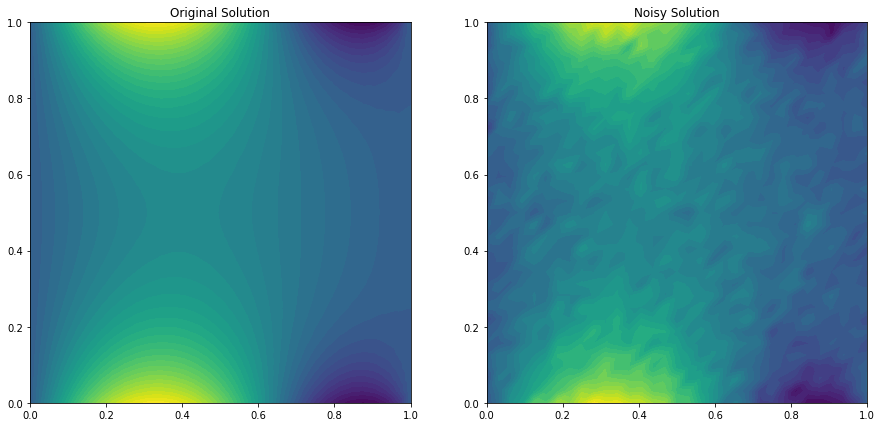

In [8]:

plt.figure(figsize=(15,10))

plt.subplot(121)
dl.plot(u)
plt.title('Original Solution')

plt.subplot(122)
dl.plot(predFunc,colorbar=False)
plt.title('Noisy Solution')

plt.show()

## Bonus 1:   Expression inputs
In addition to field quantities, like the conductivity `K`, the MUQ FenicsPiece can use expression parameters as inputs.    

Recall that the Neumann source term `g` is defined by $a \sin(bx)$.  In this cell, we will create a MUQ WorkPiece with two inputs: the conductivity $K$ like before, and a vector of these expression parameters, given by $[a,b]$.  

An expression input is defined by a list of the form `[expr, ['varName1', 'varName2']]`, where expression is a Fenics expression and `'varName1'` and `'varName2'` are strings denotig scalar parameters in the expression `expr`.

In [9]:
piece2 = mm.FenicsPiece(prob, u, [K, [g, ['a','b']]])

## Bonus 2: Multi-Input evaluation
This cell evaluates the new multi-input workpiece at two different frequencies `b` in the Neumann boundary condition.

In [10]:
ab_vec = np.array([20.0, 1.0])
pred2 = piece2.Evaluate([K_vec, ab_vec])[0]

ab_vec[1] = 10.0
pred3 = piece2.Evaluate([K_vec, ab_vec])[0]

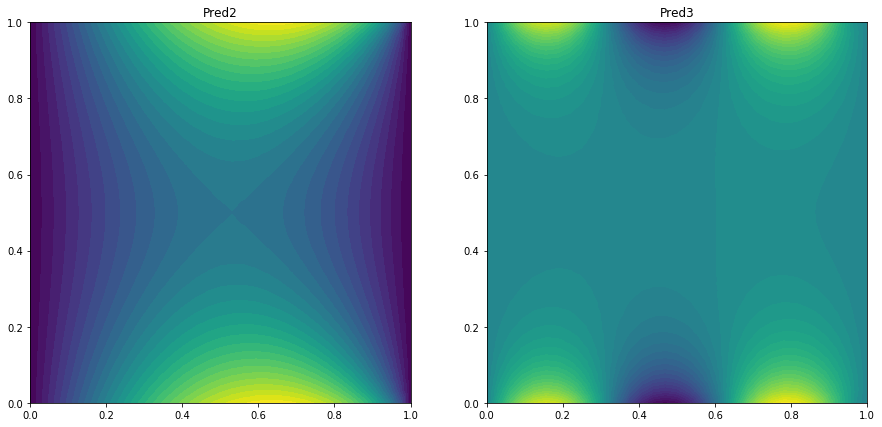

In [11]:
plt.figure(figsize=(15,10))

predFunc2 = dl.Function(V)
predFunc2.vector().set_local(pred2)

predFunc3 = dl.Function(V)
predFunc3.vector().set_local(pred3)

plt.subplot(121)
dl.plot(predFunc2)
plt.title('Pred2')

plt.subplot(122)
dl.plot(predFunc3)
plt.title('Pred3')

plt.show()